## Image segmentation

In digital image processing and computer vision, image segmentation is the process of partitioning a digital image into multiple segments

we are going to start our code with importing required keras and utility packages

So far you have seen image classification, where the task of the network is to assign a label or class to an input image. However, suppose you want to know where an object is located in the image, the shape of that object, which pixel belongs to which object, etc. In this case you will want to segment the image, i.e., each pixel of the image is given a label. Thus, the task of image segmentation is to train a neural network to output a pixel-wise mask of the image. This helps in understanding the image at a much lower level, i.e., the pixel level. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging to name a few.

The dataset that will be used for this tutorial is the Oxford-IIIT Pet Dataset, created by Parkhi et al. The dataset consists of images, their corresponding labels, and pixel-wise masks. The masks are basically labels for each pixel. Each pixel is given one of three categories :

Class 1 : Pixel belonging to the pet.
Class 2 : Pixel bordering the pet.
Class 3 : None of the above/ Surrounding pixel.

[link text](https://https://www.robots.ox.ac.uk/~vgg/data/pets/)

In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git #downloading the tensorflow latest version
!pip install -q -U tfds-nightly #Installing the latest version nightly 

In [ ]:
import tensorflow as tf # importing the tensorflow for the multidimensional analysis

In [ ]:

import tensorflow_datasets as tfds #downloading for the dataset
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt #ploting the dataset
from tensorflow.python.keras.models import Model # keras function for model loading 


from tensorflow.python.keras import backend as K #running the keras as background
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout #loading the layers functions
from tensorflow.python.keras.optimizers import Adadelta, Nadam ,Adam #loading the optimiziers functions

from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras.preprocessing.image import load_img,img_to_array
import tensorflow as tf
from tensorflow.python.keras.losses import binary_crossentropy #loading the loss functions 

Download the Oxford-IIIT Pets dataset
The dataset is already included in TensorFlow datasets, all that is needed to do is download it. The segmentation masks are included in version 3+.bold text

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True) # Downloading the dataset

The following code performs a simple augmentation of flipping an image. In addition, image is normalized to [0,1]. Finally, as mentioned above the pixels in the segmentation mask are labeled either {1, 2, 3}. For the sake of convenience, let's subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}.

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [ ]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask


The dataset already contains the required splits of test and train and so let's continue to use the same split.




In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

Let's take a look at an image example and it's correponding mask from the dataset.



In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

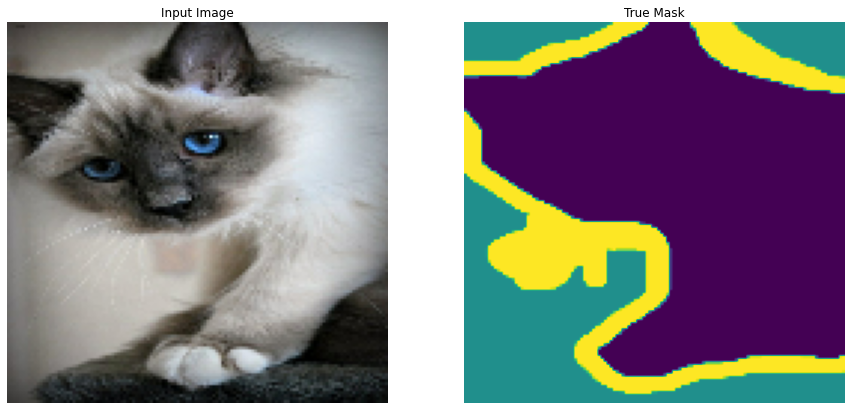

In [ ]:
for image, mask in train.take(33):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

After preparing input pipeline we are going to define our U-net model
here we first define down convolution (encoder ) and up convolution layer (decoder) and stack them up with a short circuting features from down sampling to corresponding up sampling

full detail of the architecture is present here - https://arxiv.org/abs/1505.04597

In [ ]:
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y


def Unet(h, w, filters):
# down
    input_layer = Input(shape=(h, w, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5)(conv5)
# up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7) 
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
    output_layer = Conv2D(filters=3, kernel_size=(1, 1), activation='softmax')(deconv9)
    # using softmax activation for multiple classification
    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model

In [ ]:
model = Unet(224 , 224 , 34)

In [ ]:
model.summary()

Model: "Unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 34) 952         image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 34) 136         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 34) 0           batch_normalization[0][0]        
_______________________________________________________________________________________________

Train the model
Now, all that is left to do is to compile and train the model. The loss being used here is losses.SparseCategoricalCrossentropy(from_logits=True). The reason to use this loss function is because the network is trying to assign each pixel a label, just like multi-class prediction. In the true segmentation mask, each pixel has either a {0,1,2}. The network here is outputting three channels. Essentially, each channel is trying to learn to predict a class, and losses.SparseCategoricalCrossentropy(from_logits=True) is the recommended loss for such a scenario. Using the output of the network, the label assigned to the pixel is the channel with the highest value. This is what the create_mask function is doing.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

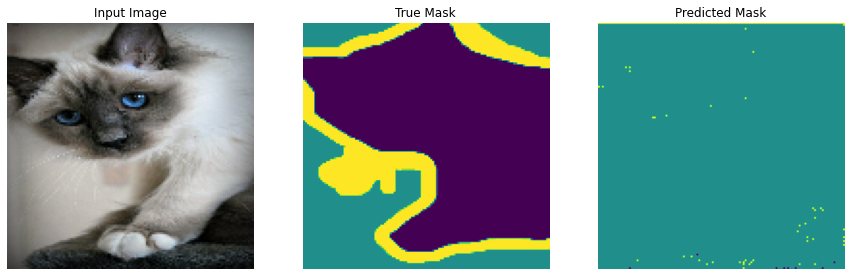

In [ ]:
show_predictions()

Let's observe how the model improves while it is training. To accomplish this task, a callback function is defined below.

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
import numpy as np

EPOCHS = 500
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit((train_dataset), epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=(test_dataset),
)


Epoch 1/500


 2/57 [>.............................] - ETA: 13s - loss: 1.0352 - accuracy: 0.5052WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1691s vs `on_train_batch_end` time: 0.3077s). Check your callbacks.


57/57 [==============================] - ETA: 0s - loss: 0.8317 - accuracy: 0.7182WARNING:tensorflow:Model was constructed with shape (None, 224, 224, 3) for input Tensor("image_input:0", shape=(None, 224, 224, 3), dtype=float32), but it was called on an input with incompatible shape (None, 128, 128, 3).


57/57 [==============================] - 29s 517ms/step - loss: 0.8317 - accuracy: 0.7182 - val_loss: 1.0834 - val_accuracy: 0.4605
Epoch 2/500
57/57 [==============================] - 29s 515ms/step - loss: 0.7477 - accuracy: 0.7939 - val_loss: 0.7997 - val_accuracy: 0.7368
Epoch 3/500
57/57 [==============================] - 30s 525ms/step - loss: 0.7192 - accuracy: 0.8208 - val_loss: 0.8070 - val_accuracy: 0.7291
Epoch 4/500
57/57 [==============================] - 30s 535ms/step - loss: 0.7030 - accuracy: 0.8363 - val_loss: 0.8436 - val_accuracy: 0.6956
Epoch 5/500
57/57 [==============================] - 31s 539ms/step - loss: 0.6932 - accuracy: 0.8458 - val_loss: 0.7521 - val_accuracy: 0.7865
Epoch 6/500
57/57 [==============================] - 31s 543ms/step - loss: 0.6864 - accuracy: 0.8526 - val_loss: 0.7614 - val_accuracy: 0.7782
Epoch 7/500
57/57 [==============================] - 31s 545ms/step - loss: 0.6836 - accuracy: 0.8553 - val_loss: 0.8991 - val_accuracy: 0.6401
Epoc

Make predictions
Let's make some predictions. In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results.

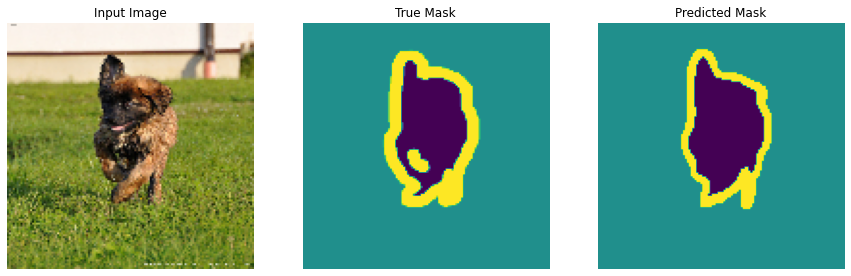

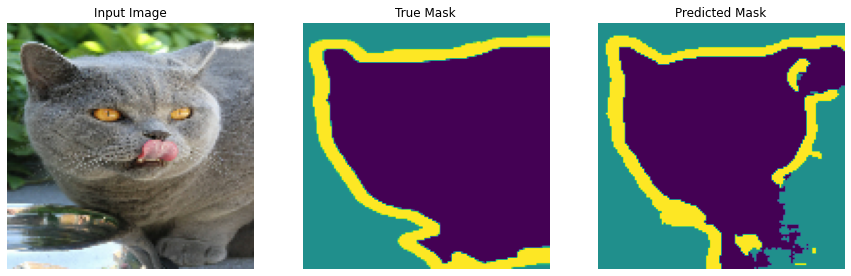

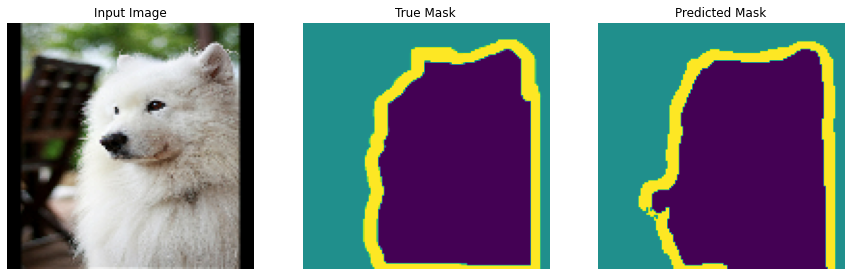

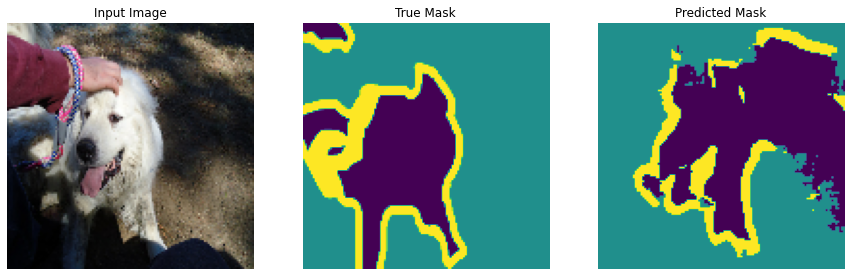

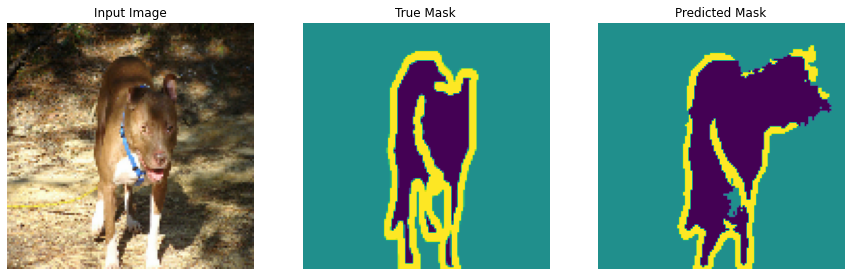

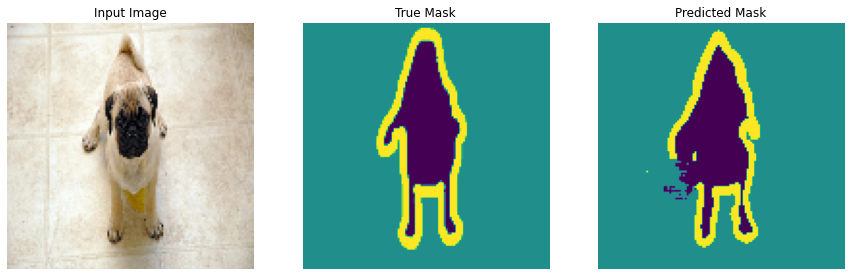

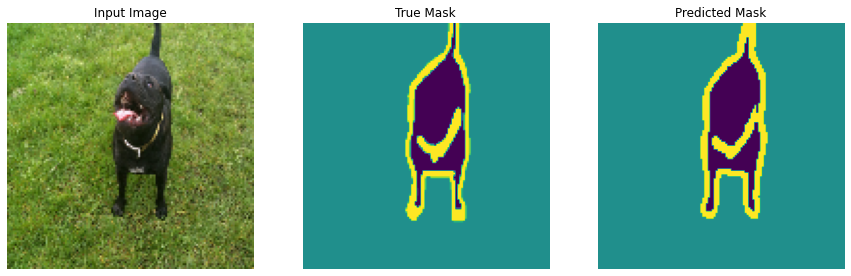

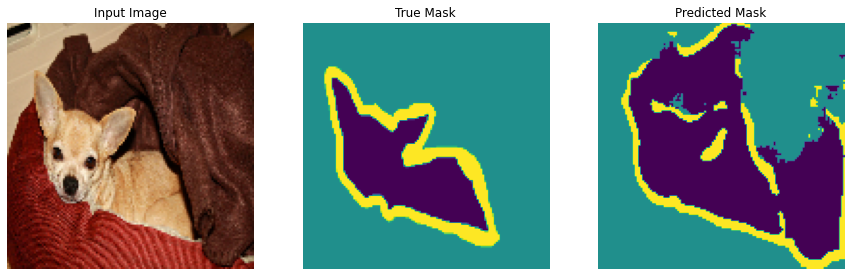

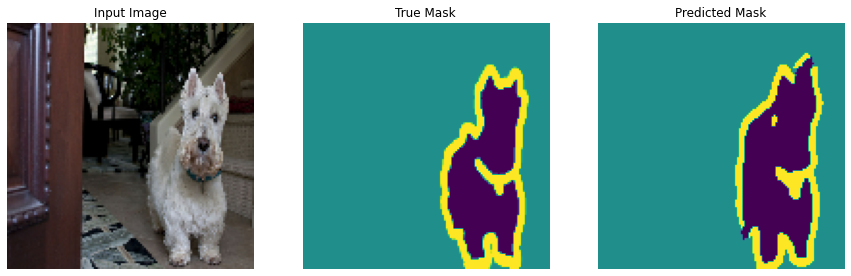

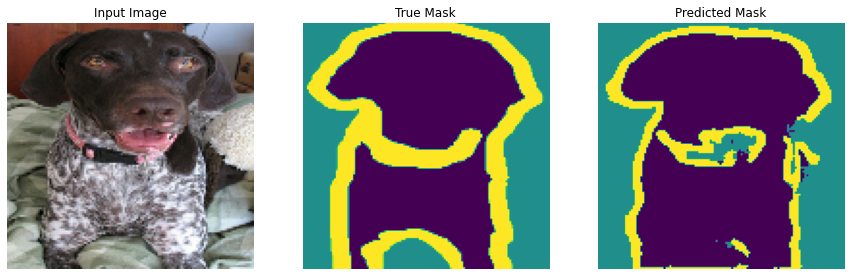

In [ ]:

show_predictions(test_dataset, 10)

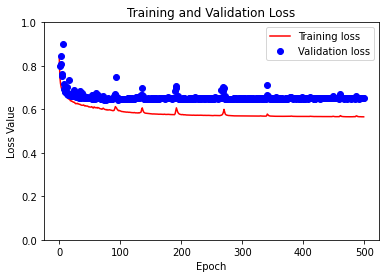

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()